https://github.com/py-why/EconML/blob/main/notebooks/CustomerScenarios/Case%20Study%20-%20Recommendation%20AB%20Testing%20at%20An%20Online%20Travel%20Company.ipynb

In [1]:
#Utilities
import numpy as np
import pandas as pd

#Generic ML import
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures

#EconML imports
from econml.iv.dr import LinearIntentToTreatDRIV
from econml.cate_interpreter import SingleTreeCateInterpreter, \
                                    SingleTreePolicyInterpreter
                                    
import matplotlib.pyplot as plt
%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
#Import the sample AB data
file_url = "https://msalicedatapublic.z5.web.core.windows.net/datasets/RecommendationAB/ab_sample.csv"
ab_data = pd.read_csv(file_url)

In [3]:
#Data sample
ab_data.head()

,days_visited_exp_pre,days_visited_free_pre,days_visited_fs_pre,days_visited_hs_pre,days_visited_rs_pre,days_visited_vrs_pre,locale_en_US,revenue_pre,os_type_osx,os_type_windows,easier_signup,became_member,days_visited_post
0,1,9,7,25,6,3,1,0.01,0,1,0,0,1
1,10,25,27,10,27,27,0,2.26,0,0,0,0,15
2,18,14,8,4,5,2,1,0.03,0,1,0,0,17
3,17,0,23,2,3,1,1,418.77,0,1,0,0,6
4,24,9,22,2,3,18,1,1.54,0,0,0,0,12


In [4]:
#Define estimator inputs 
Z = ab_data['easier_signup'] # nudge, or instrument
T = ab_data['became_member'] # Intervention, or treatment
Y = ab_data['days_visited_post'] # Outcome of interest
X_data = ab_data.drop(columns = ['easier_signup','became_member','days_visited_post']) #Features 

In [5]:
#Define underlying treatment effect function
def TE_fn(X):
    return (0.2 + 0.3 * X['days_visited_free_pre'] - 0.2 * X['days_visited_hs_pre'] + X['os_type_osx']).values

true_TE = TE_fn(X_data)

# Define the true coefficients to compare with
true_coefs = np.zeros(X_data.shape[1])
true_coefs[[1, 3, -2]] = [0.3, -0.2, 1]

In [6]:
# Define nuissance estimators 
lgb_T_XZ_params = {
    'objective' : 'binary', # Binary Classification Task (e.g: predicting treatment assignment.)
    'metric' : 'auc',       # Evaluation metric: Area Under the Curve (AUC) for classification performance
    'learning_rate' : 0.1,  # Controls how much weights are adjusted with each boosting step.
    'num_leaves' : 30,      # Maximum number of leaf nodes per tree ( controls model complexity)
    'max_depth' :5          # Maximum depth of trees (prevents overfitting by limiting tree size)
}

lgb_Y_X_params = {
    'metric' : 'rmse',      # Evaluation metric : Root Mean Squared Error (RMSE) for regression.
    'learning_rate' : 0.1,
    'num_leaves' : 30,
    'max_depth': 5
}

model_T_XZ = lgb.LGBMClassifier(**lgb_T_XZ_params)
model_Y_X = lgb.LGBMRegressor(**lgb_Y_X_params)
flexible_model_effect = lgb.LGBMRegressor(**lgb_Y_X_params)

In [ ]:
# Train EconML model
model = LinearIntentToTreatDRIV(
    model_y_xw= model_Y_X,
    model_t_xwz= model_T_XZ,
    flexible_model_effect= flexible_model_effect,
    featurizer= PolynomialFeatures(degree = 1, include_bias= False)
)
model.fit(Y, T, Z=Z, X = X_data, inference="statsmodels")

In [10]:
# Compared learned coefficients with true model coefficients 
coef_indices = np.arange(model.coef_.shape[0])

# Calculate error bars 
coef_error = np.asarray(model.coef__interval()) # 95% confidence interval for coefficients 
coef_error[0, :] = model.coef_ - coef_error[0, :]
coef_error[1, :] = coef_error[1, :] - model.coef_

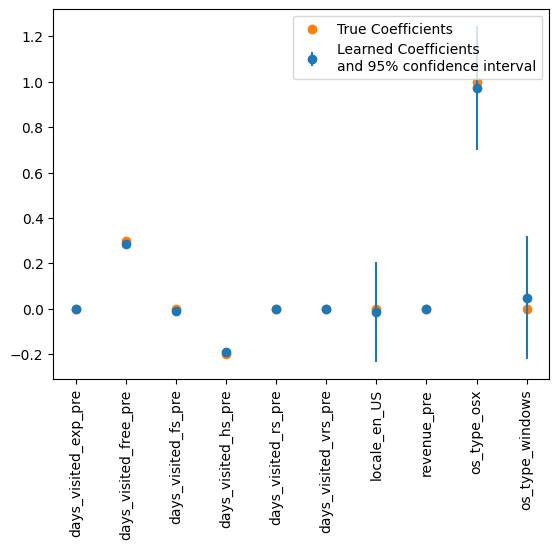

In [15]:
plt.errorbar(coef_indices, model.coef_, coef_error, fmt = 'o', label = 'Learned Coefficients\nand 95% confidence interval')
plt.scatter(coef_indices, true_coefs, color='C1', label = 'True Coefficients')
plt.xticks(coef_indices, X_data.columns, rotation = 'vertical')
plt.legend()
plt.show()

In [16]:
model.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
days_visited_exp_pre,0.001,0.007,0.212,0.832,-0.012,0.015
days_visited_free_pre,0.286,0.007,38.545,0.0,0.272,0.301
days_visited_fs_pre,-0.01,0.007,-1.414,0.157,-0.023,0.004
days_visited_hs_pre,-0.191,0.007,-28.341,0.0,-0.205,-0.178
days_visited_rs_pre,0.001,0.007,0.157,0.875,-0.012,0.014
days_visited_vrs_pre,-0.002,0.007,-0.352,0.725,-0.016,0.011
locale_en_US,-0.013,0.113,-0.118,0.906,-0.235,0.208
revenue_pre,-0.0,0.0,-1.103,0.27,-0.0,0.0
os_type_osx,0.973,0.139,7.019,0.0,0.701,1.245
os_type_windows,0.05,0.138,0.358,0.72,-0.222,0.321


In [17]:
test_customers = X_data.iloc[:1000]
true_customer_TE = TE_fn(test_customers)
model_customer_TE = model.effect(test_customers) 

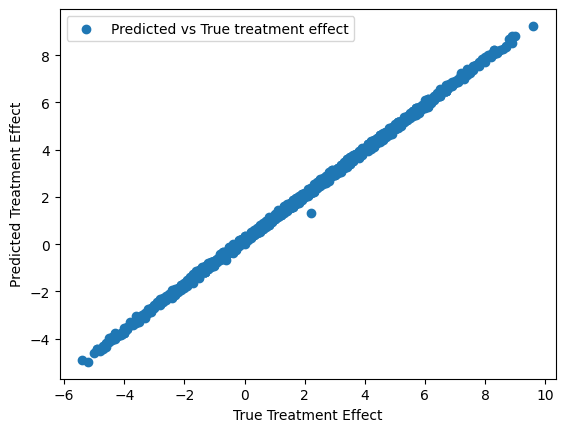

In [18]:
# How close are the predicted treatment effect to the true treatment effects for 1000 users
plt.scatter(true_customer_TE, model.effect(test_customers), label = 'Predicted vs True treatment effect')
plt.xlabel('True Treatment Effect')
plt.ylabel('Predicted Treatment Effect')
plt.legend()
plt.show()

X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names


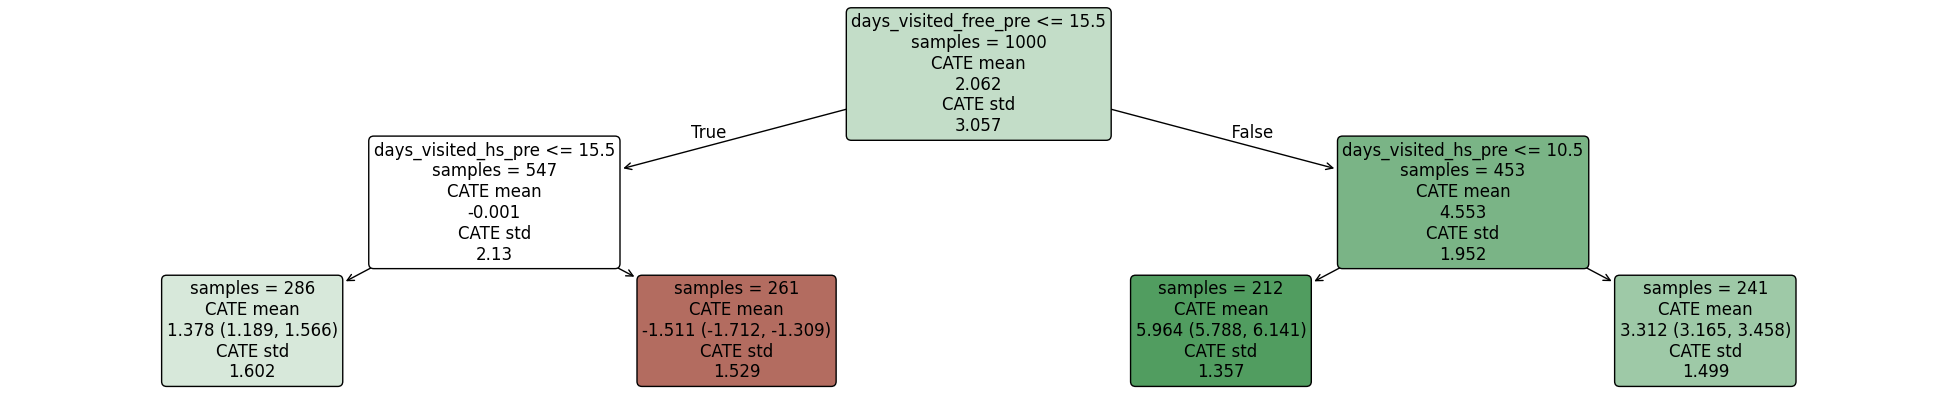

In [20]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth= 2, min_samples_leaf=10)
intrp.interpret(model, test_customers)
plt.figure(figsize=(25,5))
intrp.plot(feature_names=X_data.columns, fontsize = 12)

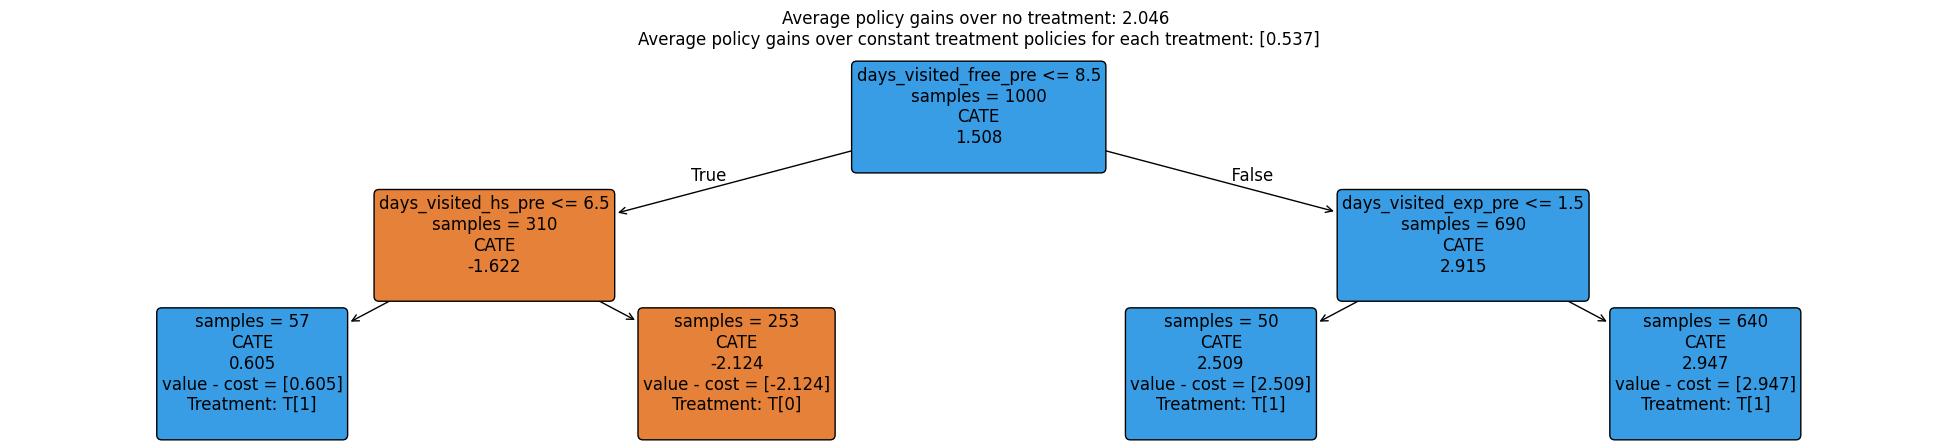

In [21]:
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=2, min_samples_leaf=10)
intrp.interpret(model, test_customers, sample_treatment_costs=0.2)
plt.figure(figsize=(25,5))
intrp.plot(feature_names=X_data.columns, fontsize=12)